In [160]:
import numpy as np
import librosa
from librosa import display
import os
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from matplotlib import pyplot as plt
from model import model_siamese_a2w_1fc
from keras.models import Model
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dense, Activation, Input, dot, concatenate
from keras.regularizers import l2

In [161]:
sample_rate = 22050
melBin = 128
hop = 5122
window = 1024
fft_size = 1024


In [162]:
X_split, Y_split = pickle.load(open('data_common/fma/tag_key_split_TGS03.p','rb'))

In [181]:
tag_key_to_embedding_dict = pickle.load(open('./pred_embeddings/exp_fma__inst-pnconf40_TGS03_TRS03_B/tag_key_to_embedding_dict_w-ep_44-loss_3.93.h5.p','rb'))
tag_list = pickle.load(open('data_common/fma/tag_ids_in_key_order.p','rb'))
genres = pd.read_csv('fma_metadata/genres.csv',index_col=0)
tracks = pd.read_csv('fma_metadata/tracks.csv',index_col=0, header=[0,1])
tag_key_to_id_dict = pickle.load(open("data_common/fma/tag_key_to_id_dict.p","rb"))

In [182]:

def get_top_cos_sim(cos_sim_vector,top):
    return np.argsort(cos_sim_vector)[-1*top:][::-1]


def get_genre_list_from_genre_id(genre_id_list):
    tmp = []
    for i in genre_id_list:
        tmp.append(genres.loc[i]['title'])
    return tmp

def get_genre_from_track(track_id):
    if track_id in tracks.index:
        word = tracks.loc[track_id]['track','genres']
#     if(word=='' or word=='[]'): return []
        word = word[1:-1]
        num_list = word.split(',')
        num_list = list(map(int, num_list))
        return num_list
    else:
        return []

In [183]:
def print_mel(input_name):
    y, _ = librosa.load(input_name, sr = sample_rate, mono = True)
    if y.shape[0] < 3000:
        print("audio length is too short!")
        return
    S = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=melBin)
    plt.figure(figsize = (10,4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    display.specshow(S_dB, x_axis='time',y_axis = 'mel',sr=sample_rate, fmax= 8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

In [184]:
def convert_to_input_mel(input_name):
    audio, _ = librosa.load(input_name, sr = sample_rate, mono = True)
    if audio.shape[0] < 3000:
        print("audio length is too short!")
        return
    D = librosa.stft(audio, n_fft = fft_size, win_length = window,  window = 'hann', hop_length = hop)
    y = np.abs(D)
    
    mel_basis = librosa.filters.mel(sample_rate, fft_size, n_mels=melBin)
    y = np.dot(mel_basis,y)
    y = np.log10(1+10*y)
    y = y.T
    return y

/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


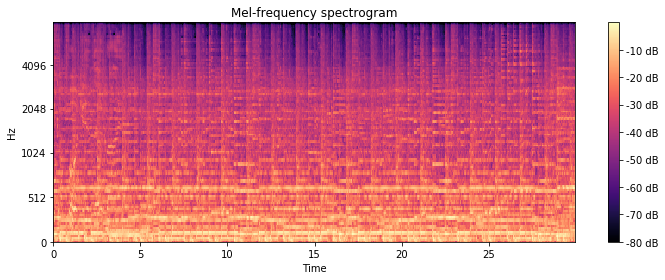

In [185]:
print_mel(input_name)

In [186]:
y = convert_to_input_mel(input_name)

/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [187]:
def myModel(argDict):
    num_frame = argDict['num_frame']
    num_negative_sampling = argDict['num_negative_sampling']    
    #audio anchor
    myModel.audio_input = Input(shape=(num_frame, 128), name='am_input')
    #positive word
    myModel.pos_item = Input(shape=(argDict['tag_vec_dim'],))
    #negative word
    myModel.neg_items = [Input(shape=(argDict['tag_vec_dim'],)) for j in range(num_negative_sampling)]
    
    #audio model
    
    conv1 = Conv1D(128,4, padding='same', use_bias=True, kernel_regularizer=l2(1e-5), kernel_initializer='he_uniform', name='am_conv_1')
    activ1 = Activation('relu')
    MP1 = MaxPool1D(pool_size=4)
    conv2 = Conv1D(128, 4, padding='same', use_bias=True, kernel_regularizer=l2(1e-5), kernel_initializer='he_uniform', name='am_conv_2')
    activ2 = Activation('relu')
    MP2 = MaxPool1D(pool_size=4)
    conv3 = Conv1D(128, 4, padding='same', use_bias=True, kernel_regularizer=l2(1e-5), kernel_initializer='he_uniform', name='am_conv_3')
    activ3 = Activation('relu')
    MP3 = MaxPool1D(pool_size=4)
    conv4 = Conv1D(128, 2, padding='same', use_bias=True, kernel_regularizer=l2(1e-5), kernel_initializer='he_uniform', name='am_conv_4')
    activ4 = Activation('relu')
    MP4 = MaxPool1D(pool_size=2)
    conv5 = Conv1D(100, 1, padding='same', use_bias=True, kernel_regularizer=l2(1e-5), kernel_initializer='he_uniform', name='am_conv_5')
    
    #(batch, steps, features) -> (batch, features)
    GP = GlobalAvgPool1D()
    
    fc1 = Dense(100)
    
    #Audio Anchor
    anchor_conv1 = conv1(myModel.audio_input)
    anchor_activ1 = activ1(anchor_conv1)
    anchor_MP1 = MP1(anchor_activ1)
    anchor_conv2 = conv2(anchor_MP1)
    anchor_activ2 = activ2(anchor_conv2)
    anchor_MP2 = MP2(anchor_activ2)
    anchor_conv3 = conv3(anchor_MP2)
    anchor_activ3 = activ3(anchor_conv3)
    anchor_MP3 = MP3(anchor_activ3)
    anchor_conv4 = conv4(anchor_MP3)
    anchor_activ4 = activ4(anchor_conv4)
    anchor_MP4 = MP4(anchor_activ4)
    anchor_conv5 = conv5(anchor_MP4)
    myModel.anchor_output = GP(anchor_conv5)
    
    #positive word item
    myModel.pos_item_output = fc1(myModel.pos_item)
    
    #negative word item
    myModel.neg_item_output = [fc1(neg_item) for neg_item in myModel.neg_items]
    
    RQD_p = dot([myModel.anchor_output, myModel.pos_item_output], axes=1, normalize=True)
    RQD_ns = [dot([myModel.anchor_output, neg_item], axes = 1, normalize=True) for neg_item in myModel.neg_item_output]
    
    prob = concatenate([RQD_p]+RQD_ns)
    
    output = Activation('linear')(prob)
    
    model = Model(inputs=[myModel.audio_input, myModel.pos_item]+myModel.neg_items, outputs = output)
    
    return model
    

In [188]:
argDict = dict()

#parser = argparse.ArgumentParser(description="load weights for predict")
argDict['load_weights'] = "weights/exp_fma__inst-pncnt40_TGS03_TRS03_A/w-ep_80-loss_6.21.h5"


# Path settings
argDict['dir_mel'] = "./fma_large_mel"
argDict['num_part'] = 12
argDict['num_negative_sampling'] = 1
argDict['global_mel_mean']= 0.2262
argDict['global_mel_std'] = 0.2579
argDict['num_frame'] = 130

exp_dir_info = argDict['load_weights'].split('/')[1]

argDict['dataset'] = argDict['load_weights'].split('/')[1].split('_')[1]
argDict['exp_info'] = argDict['load_weights'].split('/')[1].split('_')[2]
argDict['tag_vector_type'] = argDict['load_weights'].split('/')[1].split('_')[3]
argDict['tag_split_name'] = argDict['load_weights'].split('/')[1].split('_')[4]
argDict['track_split_name']= argDict['load_weights'].split('/')[1].split('_')[5]
argDict['track_split'] = argDict['load_weights'].split('/')[1].split('_')[6]


data_common_path = os.path.join('data_common', argDict['dataset'])
data_tag_vector_path = os.path.join('data_tag_vector', argDict['dataset'])
argDict['data_common_path'] = data_common_path
argDict['tag_vec_dim'] = 40

In [189]:
model = myModel(argDict)

model.load_weights(argDict['load_weights'])

audio_model = Model(inputs=myModel.audio_input,
                   outputs=myModel.anchor_output)
word_model = Model(inputs=myModel.pos_item,
                  outputs=myModel.pos_item_output)

In [190]:
def get_embedding(input_name):
    mel = convert_to_input_mel(input_name)
    while mel.shape[0]< argDict['num_frame']:
        mel = np.concatenate((mel, mel), axis=0)
    num_seg = int(mel.shape[0]/argDict['num_frame'])
    audio_seg_list=[] # 프레임단위(3초)로 끊어서 표준화한 뒤 리스트에저장
    for seg_idx in range(num_seg):
        audio_seg = mel[seg_idx * argDict['num_frame']:(seg_idx+1) * argDict['num_frame']]
        audio_seg -= argDict['global_mel_mean'] # 0.2262
        audio_seg /= argDict['global_mel_std'] # 0.2579
        # 평균0 표준편차1 로 normalization
        audio_seg_list.append(audio_seg)
    predicted = audio_model.predict(np.array(audio_seg_list))
    # 3초씩 끊은 mel spectrogram들의 평균 embedding vector를 구함
    predict_embedding = np.mean(predicted, axis=0)
    predict_embedding = predict_embedding.reshape(1,-1)
    return predict_embedding

In [191]:
def predict_genre(input_name, num, s_us): # input_name 노래에 대해 num개의 장르를 예측해보기, Seen/Unseen에 대해
    
    predict_embedding = get_embedding(input_name)
    cur_tag_embeddings = []
    X_split, Y_split = pickle.load(open('data_common/fma/tag_key_split_TGS03.p','rb'))
    if(s_us=='Y'):
        tag_list = Y_split
    elif(s_us=='XY'):
        tag_list = X_split+Y_split
    for tag_key in range(len(tag_list)):
        cur_tag_embeddings.append(tag_key_to_embedding_dict[tag_key].squeeze())
    cur_tag_embeddings = np.array(cur_tag_embeddings)
    cos_sim_vector = cosine_similarity(predict_embedding, cur_tag_embeddings)
    cos_sim_vector = cos_sim_vector[0]
    
    top_genre_key_list = get_top_cos_sim(cos_sim_vector,num) # 탑 num개의 장르키 리스트를 리턴
#     print("top_genre_key_list:",top_genre_key_list)
    top_genre_id_list = []
    for genre_key in top_genre_key_list:
        top_genre_id_list.append(tag_key_to_id_dict[genre_key])
    gen_list = get_genre_list_from_genre_id(top_genre_id_list) # 장르리스트 리턴
    print("이 노래는 이렇게 예측되었습니다:{}".format(gen_list))
    input_name = input_name.strip('.mp3')
    track_id = int(input_name.split('/')[-1])
#     track_id = int(input_name.split('.')[0])
#     print("track_id:",track_id)
    gen_true_id_list = get_genre_from_track(track_id)
    gen_true_id_list = np.array(gen_true_id_list)
#     print("gen_true_id_list:", gen_true_id_list)
    gen_true_list = get_genre_list_from_genre_id(gen_true_id_list)

    print("이 노래는 사실 이 장르입니다:{}".format(gen_true_list))

In [192]:
def get_file_path_for_test(split_type):  #  split_type: B, C, BC
    track_keys_split = []
    if(split_type=='B'):
        track_keys_split = pickle.load(open('data_common/fma/track_keys_B_TRS03_TGS03.p', 'rb'))
        track_keys_split= track_keys_split[0]
    elif(split_type=='C'):
        track_keys_split = pickle.load(open('data_common/fma/track_keys_C_TRS03_TGS03.p', 'rb'))
    elif(split_type=='BC'):
        track_keys_B = pickle.load(open('data_common/fma/track_keys_B_TRS03_TGS03.p', 'rb'))
        track_keys_B = track_keys_B[0]
        track_keys_C = pickle.load(open('data_common/fma/track_keys_C_TRS03_TGS03.p', 'rb'))
        track_keys_split = track_keys_B+track_keys_C
#         print(track_keys_split)
    track_key_to_id_dict = pickle.load(open("data_common/fma/track_key_to_id_dict.p",'rb'))
    track_id_to_file_path_dict = pickle.load(open("data_common/fma/track_id_to_file_path_dict.p","rb"))
    
    testFilePath=[]
    for key in track_keys_split:
        track_id = track_key_to_id_dict[key]
        file_path = track_id_to_file_path_dict[track_id]
        testFilePath.append("../fma_large/" +file_path.replace("mel.npy","mp3"))
    return testFilePath

In [193]:
def test_for_dataset(split_name, s_us, top, stidx, endidx):
    testFilePath = get_file_path_for_test(split_name)
    for i in range(stidx,endidx):
        predict_genre(testFilePath[i],top, s_us)
        print()

In [198]:
test_for_dataset('BC','Y',5,20,30) # A트레인셋에 대해 C-XY로 상위 5개의 라벨링을 뽑아 보았다.

/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Noise', 'Audio Collage', 'Electronic', 'Experimental', 'Spoken']
이 노래는 사실 이 장르입니다:['Avant-Garde', 'Experimental']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Metal', 'Noise', 'Audio Collage', 'Old-Time / Historic', 'Punk']
이 노래는 사실 이 장르입니다:['Experimental', 'Drone', 'Musique Concrete', 'Minimalism']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Noise', 'Electronic', 'Audio Collage', 'Experimental', 'Field Recordings']
이 노래는 사실 이 장르입니다:['Avant-Garde', 'Electronic', 'Experimental']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Noise', 'Metal', 'Audio Collage', 'Punk', 'Spoken']
이 노래는 사실 이 장르입니다:['Electronic', 'Krautrock', 'Ambient']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Audio Collage', 'Old-Time / Historic', 'Noise', 'Field Recordings', 'Spoken']
이 노래는 사실 이 장르입니다:['Folk', 'Free-Folk', 'Improv']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Spoken', 'Blues', 'Audio Collage', 'Sound Effects', 'Metal']
이 노래는 사실 이 장르입니다:['International', 'Free-Jazz', 'Improv']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Spoken', 'Audio Collage', 'Electronic', 'Easy Listening', 'Post-Rock']
이 노래는 사실 이 장르입니다:['Lo-Fi', 'Freak-Folk']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Spoken', 'Metal', 'Audio Collage', 'Blues', 'Punk']
이 노래는 사실 이 장르입니다:[]



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Spoken', 'Audio Collage', 'Noise', 'Electronic', 'Metal']
이 노래는 사실 이 장르입니다:['Polka', 'Romany (Gypsy)']



/home/lab08/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


이 노래는 이렇게 예측되었습니다:['Spoken', 'Noise', 'Punk', 'Metal', 'Rock']
이 노래는 사실 이 장르입니다:['Avant-Garde', 'Lo-Fi', 'Experimental Pop']

